In [2]:
pal = [(39/255,95/255,153/255),(80/255,176/255,220/255),
       (237/255,244/255,248/255),
       (146/255,144/255,142/255),
       (78/255,78/255,80/255),
(235/255,154/255,88/255),(87/255,126/255,130/255)]

import matplotlib.colors as mcolors
import sklearn.cluster
import numpy as np
import argparse
import cv2

from tqdm import tqdm
import sys
sys.path.append("/Users/rcarlson/Documents/GitHub/lasagna3/snakes")
import mahotas
from ops.imports_ipython import *

import skimage
import umap.umap_ as umap
import stringdb



###  Figure 1 Genome-wide volcano


/Users/rcarlson/miniconda3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rcarlson/miniconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/rcarlson/miniconda3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rcarlson/miniconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in

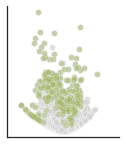

In [201]:
df = pd.read_csv('../Data/TableS3.csv')
df.index = df.gene_symbol
secgenes = df.loc[(~pd.isnull(df.mean_transloc_secondary_reporter)) & (~pd.isnull(df.mean_transloc_secondary_antibody))].index

##

sns.set(font_scale=2) 
sns.set_style("white")
plt.figure(figsize = (2,2.4))
g=sns.scatterplot(df.mean_transloc_primary, -np.log10(df.fdr_bh_adj_p_primary),
                c = mcolors.to_rgba('#d3d3d3'), alpha = .7)
g=sns.scatterplot(df[df.index.isin(secgenes)].mean_transloc_primary, -np.log10(df[df.index.isin(secgenes)].fdr_bh_adj_p_primary), 
                 c=pal[2], alpha = .4)
# g=sns.scatterplot(df[df.index.isin(highhits)].mean_transloc_secondary_antibody, -np.log10(df[df.index.isin(highhits)].fdr_bh_adj_p_secondary_antibody), 
#                c=pal[0])
# g=sns.scatterplot(x = df[df.index == "nontargeting"].mean_transloc_secondary_antibody, 
#                 y = -np.log10(df[df.index  == "nontargeting"].fdr_bh_adj_p_secondary_antibody),
#                   c = mcolors.to_rgba('#404040'))
sns.despine(top = True, right = True)

plt.xlabel('')
plt.ylabel('')
g.set_xticklabels('')
g.set_yticklabels('')

plt.xlim(-.17,.17)
plt.savefig('/Users/rcarlson/Documents/IRF3 Paper/Figures/F1/gw_volcano.tif', dpi = 600, bbox_inches = 'tight')


### Figure 1 Positive control histograms

In [5]:
df = pd.read_pickle('../Data/F1/genomewide_positive_controls.pkl')

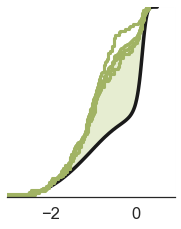

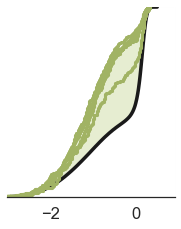

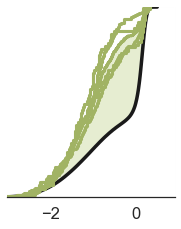

In [8]:
sns.set(font_scale=1.5) 
sns.set_style("white")
feature = 'dapi_corrch2_nuclear_corr'
for gene in ['DDX58', 'MAVS', 'IRF3']:
    plt.figure(figsize = (3,3.5))
    ax=sns.ecdfplot(df.query('gene_symbol == "nontargeting"')[feature].dropna(),
                   color='k',linewidth=3.5)


    ax = sns.ecdfplot(df.query('gene_symbol == @gene')[feature].dropna(),
                   color=pal[2],linewidth=3.1)
    for sg in pd.unique(df.query('gene_symbol == @gene').sgRNA):
        
        ax = sns.ecdfplot(df.query('sgRNA == @sg')[feature].dropna(),
                   color=pal[2],linewidth=3.1)
        sns.despine(top = True, right = True, left = True)
    l1 = ax.lines[0]
    x1, y1 = l1.get_xydata().T 
    l2 = ax.lines[1]
    x2, y2 = l2.get_xydata().T 
    xmin = -3
    xmax = .9
    x = np.linspace(xmin, xmax, 500)
    y1 = np.interp(x, x1, y1)
    y2 = np.interp(x, x2, y2)
    y = np.minimum(y1, y2)
    plt.fill_between(x, y2, 0, facecolor=(230/255, 237/255, 209/255))
    plt.fill_between(x, y1, 0, facecolor='white')

    plt.xlabel('')
    plt.xlim(xmin, xmax)
    plt.ylabel('')
    ax.set(yticks=[])

    plt.savefig('%s_irf3_transloc_hist.tif'%gene, dpi = 400, bbox_inches = 'tight')
    plt.show()

### Figure 1 Primary secondary screen correlations


In [3]:
df = pd.read_csv('../Data/TableS3.csv')
df.index = df.gene_symbol

In [114]:
lowhitsreporter = (df.query('fdr_bh_adj_p_secondary_reporter < .1 & mean_transloc_secondary_reporter < 0')
               .sort_values('mean_transloc_secondary_reporter').index)

highhitsreporter = (df.query('fdr_bh_adj_p_secondary_reporter < .1 & mean_transloc_secondary_reporter > 0')
                .sort_values('mean_transloc_secondary_reporter', ascending = False).index)
print(len(lowhitsreporter))
print(len(highhitsreporter))

49
55


In [115]:
lowhitsantibody = (df.query('fdr_bh_adj_p_secondary_antibody < .1 & mean_transloc_secondary_antibody < 0')
               .sort_values('mean_transloc_secondary_antibody').index)

highhitsantibody = (df.query('fdr_bh_adj_p_secondary_antibody < .1 & mean_transloc_secondary_antibody > 0')
                .sort_values('mean_transloc_secondary_antibody', ascending = False).index)
print(len(lowhitsantibody))
print(len(highhitsantibody))

39
56


In [122]:
lowhits = list(set(lowhitsantibody) & set(lowhitsreporter))
highhits = list(set(highhitsantibody) & set(highhitsreporter))
lowhits = lowhits + ['IRF3']

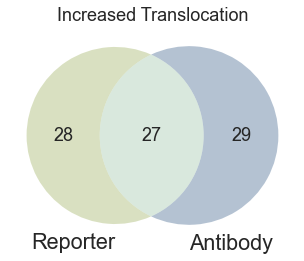

In [123]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
venn2([set(highhitsreporter), set(highhitsantibody)], 
      set_labels = ['Reporter','Antibody'], set_colors = (pal[2], pal[1], pal[3]))
plt.title('Increased Translocation')
plt.show()

##

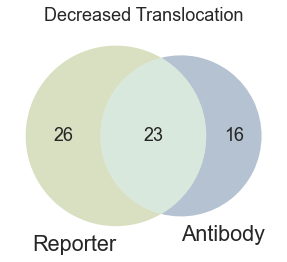

In [124]:
venn2([set(lowhitsreporter), set(lowhitsantibody)], 
      set_labels = ['Reporter','Antibody'], set_colors = (pal[2], pal[1], pal[3]))
plt.title('Decreased Translocation')
plt.show()

##

In [4]:
df = df.loc[(~pd.isnull(df.mean_transloc_secondary_reporter)) & (~pd.isnull(df.mean_transloc_secondary_antibody))]

/Users/rcarlson/miniconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/rcarlson/miniconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/rcarlson/miniconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  Fut

(0.6535764523334221, 2.5942994433707566e-42)
(0.5036127817344811, 5.220026302957954e-23)


/Users/rcarlson/miniconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


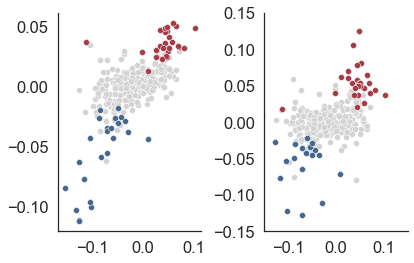

In [146]:
print(scipy.stats.pearsonr(df.mean_transloc_secondary_antibody,df.mean_transloc_primary))
print(scipy.stats.pearsonr(df.mean_transloc_secondary_reporter,df.mean_transloc_primary))


fig, (ax1,ax2)  = plt.subplots(1,2)
fig.tight_layout()

sns.set(font_scale=1) 
sns.set_style("white")
sns.scatterplot(df.mean_transloc_primary,df.mean_transloc_secondary_antibody,
                c = mcolors.to_rgba('#d3d3d3'), ax = ax1)
sns.scatterplot(df[df.index.isin(lowhits)].mean_transloc_primary, df[df.index.isin(lowhits)].mean_transloc_secondary_antibody,
                c=pal[1], ax = ax1)
sns.scatterplot(df[df.index.isin(highhits)].mean_transloc_primary, df[df.index.isin(highhits)].mean_transloc_secondary_antibody,
               c=pal[0], ax = ax1)
sns.despine(top = True, right = True)
ax1.set_xlabel('')
ax1.set_ylabel('')

plt.xlim(-.15,.15)
plt.ylim(-.12,.12)

sns.set(font_scale=1.5) 
sns.set_style("white")
sns.scatterplot(df.mean_transloc_primary,df.mean_transloc_secondary_reporter,
                c = mcolors.to_rgba('#d3d3d3'), ax = ax2)
sns.scatterplot(df[df.index.isin(lowhits)].mean_transloc_primary, df[df.index.isin(lowhits)].mean_transloc_secondary_reporter,
                c=pal[1], ax = ax2)
sns.scatterplot(df[df.index.isin(highhits)].mean_transloc_primary, df[df.index.isin(highhits)].mean_transloc_secondary_reporter,
               c=pal[0], ax = ax2)
ax2.set_xlabel('')
ax2.set_ylabel('')
plt.xlim(-.15,.15)
plt.ylim(-.15,.15)


plt.savefig('../Figures/F1/primary-secondary_corr_v2.tif', dpi = 600, bbox_inches = 'tight')

plt.show()


### Figure 1 Volcano plot


/Users/rcarlson/miniconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/rcarlson/miniconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/rcarlson/miniconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  Fut

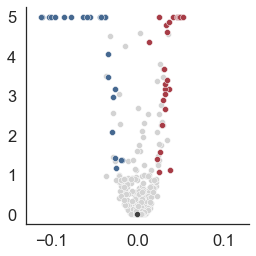

In [167]:
df = pd.read_csv('../Data/F1/TableS3.csv')
df.index = df.gene_symbol



sns.set(font_scale=1.5) 
sns.set_style("white")
plt.figure(figsize = (4,4))
g=sns.scatterplot(df.mean_transloc_secondary_antibody, -np.log10(df.fdr_bh_adj_p_secondary_antibody),
                c = mcolors.to_rgba('#d3d3d3'))
g=sns.scatterplot(df[df.index.isin(lowhits)].mean_transloc_secondary_antibody, -np.log10(df[df.index.isin(lowhits)].fdr_bh_adj_p_secondary_antibody), 
                c=pal[1])
g=sns.scatterplot(df[df.index.isin(highhits)].mean_transloc_secondary_antibody, -np.log10(df[df.index.isin(highhits)].fdr_bh_adj_p_secondary_antibody), 
               c=pal[0])
g=sns.scatterplot(x = df[df.index == "nontargeting"].mean_transloc_secondary_antibody, 
                y = -np.log10(df[df.index  == "nontargeting"].fdr_bh_adj_p_secondary_antibody),
                  c = mcolors.to_rgba('#404040'))
sns.despine(top = True, right = True)

plt.xlabel('')
plt.ylabel('')
plt.xlim(-.13,.13)
plt.savefig('../Figures/F1/irf3_volcano.tif', dpi = 600, bbox_inches = 'tight')


### Figure 2 GO


In [205]:
import gseapy as gp
enr = gp.enrichr(gene_list=pd.Series(lowhits),
                 gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                           'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Human', 
                 outdir='../Data/F2/lowhits_go',
                 cutoff=0.05 # 
                )


In [206]:
enr = gp.enrichr(gene_list=pd.Series(highhits),
                 gene_sets=['KEGG_2019_Human','GO_Biological_Process_2018',
                           'Reactome_2016', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Human', 
                 outdir='../Data/F2/highhits_go',
                 cutoff=0.05 # 
                )


### Figure 2 IRF3-SeV


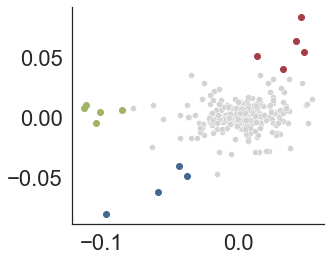

In [225]:
df = pd.read_csv('../Data/TableS3.csv')
df.index = df.gene_symbol
plt.figure(figsize = (4.5,4))

g = sns.scatterplot(x = df.mean_transloc_secondary_antibody,
                y = df.mean_sev_cell_median,color=mcolors.to_rgba('#d3d3d3'))

plt.xlabel('')
plt.ylabel('')

upgenes = df[(df.mean_sev_cell_median > .04) & (df.index.isin(list(lowhits) + list(highhits)))].index
z = df[df.index.isin(upgenes)].mean_sev_cell_median
y = df[df.index.isin(upgenes)].mean_transloc_secondary_antibody

plt.scatter(y,z,color=pal[0])

    
downgenes = df[(df.mean_sev_cell_median < -.04) & (df.index.isin(list(lowhits) + list(highhits)))].index
z = df[df.index.isin(downgenes)].mean_sev_cell_median
y = df[df.index.isin(downgenes)].mean_transloc_secondary_antibody

plt.scatter(y,z,color=pal[1])


downgenes =  df[(df.mean_transloc_secondary_antibody < -.08) & (df.mean_sev_cell_median > -.02) & (df.mean_sev_cell_median < .02) & (df.index.isin(list(lowhits) + list(highhits)))].index
z = df[df.index.isin(downgenes)].mean_sev_cell_median
y = df[df.index.isin(downgenes)].mean_transloc_secondary_antibody

plt.scatter(y,z,color=pal[2])


sns.despine(top = True, right = True)

plt.savefig('/Users/rcarlson/Documents/IRF3 Paper/Figures/F3/sev_irf3_secondary.tif', dpi = 600, bbox_inches = 'tight')

plt.show()